In [188]:
import sys
sys.path.append('/Users/noahfarr/Library/Mobile Documents/com~apple~CloudDocs/Projects/qrious/src')

In [189]:
from base.agents.actor_critic import ActorCritic
from base.environment import Environment
from base.policy import Network

import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import gymnasium as gym

In [190]:
class Actor(Network):
    
    def forward(self, x):
        logits = self.model(x)
        return Categorical(logits=logits)

In [191]:
class Critic(Network):

    def forward(self, x):
        return self.model(x)

In [192]:
import torch

class Buffer:
    def __init__(self, max_episode_steps, observation_space):
        self.max_episode_steps: int = max_episode_steps
        self.observation_space = observation_space
        self.index: int = 0
        self.observations = torch.zeros((max_episode_steps, observation_space), dtype=torch.float32)
        self.actions = torch.zeros(max_episode_steps, dtype=torch.float32)
        self.rewards = torch.zeros(max_episode_steps, dtype=torch.float32)
        self.values = torch.zeros(max_episode_steps, dtype=torch.float32)
        self.log_probs = torch.zeros(max_episode_steps, dtype=torch.float32) 

        self.old_observations = None
        self.old_actions = None
        self.old_rewards = None
        self.old_values = None
        self.old_log_probs = None

    def append(self, observation, action, reward, value):
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.values[self.index] = value
        self.index += 1
    
    def clear(self):
        self.old_observations = self.observations.clone()
        self.old_actions = self.actions.clone()
        self.old_rewards = self.rewards.clone()
        self.old_values = self.values.clone()
        self.old_log_probs = self.log_probs.clone() 

        self.index = 0
        self.observations = torch.zeros((self.max_episode_steps, self.observation_space), dtype=torch.float32)
        self.actions = torch.zeros(self.max_episode_steps, dtype=torch.float32)
        self.rewards = torch.zeros(self.max_episode_steps, dtype=torch.float32)
        self.values = torch.zeros(self.max_episode_steps, dtype=torch.float32)
        self.log_probs = torch.zeros(self.max_episode_steps, dtype=torch.float32) 

    def truncate(self):
        self.observations, self.actions, self.rewards, self.values = self.observations[:self.index], self.actions[:self.index], self.rewards[:self.index], self.values[:self.index]


In [193]:
class PPO(ActorCritic):

    def __init__(self, env, actor, critic, actor_optimizer, critic_optimizer, gamma=0.99, epsilon=0.2):
        super().__init__(env, actor, critic, actor_optimizer, critic_optimizer)
        self.gamma = gamma
        self.epsilon = epsilon
        self.old_actor = copy.deepcopy(self.actor)

    def compute_actor_loss(self, ratios, advantages):
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1-self.epsilon, 1+self.epsilon) * advantages
        return -torch.min(surr1, surr2).mean()

    def compute_critic_loss(self, rewards, values):
        return F.mse_loss(rewards, values)

    def compute_ratios(self, observations, actions):
        old_log_probs = self.old_actor(observations).log_prob(actions)
        log_probs = self.actor(observations).log_prob(actions)
        return (log_probs - old_log_probs).exp()

    def compute_advantages(self, rewards, values):
        advantages = rewards - values
        return advantages.detach()

    def sample_action(self, obs):
        action = self.actor(obs).sample().item()
        return action

    def compute_discounted_rewards(self, rewards, gamma):
        discounted_rewards = torch.zeros(len(rewards), dtype=torch.float32)
        discounted_reward = 0
        for t in reversed(range(len(rewards))):
            discounted_reward = rewards[t] + gamma * discounted_reward
            discounted_rewards[t] = discounted_reward
        return discounted_rewards
    
    
    def train(self, batches=50, episodes=10):
        returns = torch.zeros(batches*episodes, dtype=torch.float32)
        lengths = torch.zeros(batches*episodes, dtype=torch.float32)
        for batch in range(batches):
            for episode in range(episodes):
                observations = torch.zeros((self.env.env.spec.max_episode_steps, self.env.obs_space), dtype=torch.float32)
                actions = torch.zeros(self.env.env.spec.max_episode_steps, dtype=torch.float32)
                rewards = torch.zeros(self.env.env.spec.max_episode_steps, dtype=torch.float32)
                values = torch.zeros(self.env.env.spec.max_episode_steps, dtype=torch.float32)
                obs, info  = self.env.reset()
                obs = torch.as_tensor(obs, dtype=torch.float32) 
                terminated = truncated = False
                t = 0
                while not terminated and not truncated:
                    observations[t] = obs
                    action = self.sample_action(obs)
                    actions[t] = torch.tensor(action, dtype=torch.float32)
                    value = self.critic(obs)
                    values[t] = value
                    obs, reward, terminated, truncated, info = self.env.step(action)
                    obs = torch.as_tensor(obs, dtype=torch.float32) 
                    rewards[t] = reward
                    t += 1    
                observations, actions, rewards, values = observations[:t], actions[:t], rewards[:t], values[:t]
                if torch.isnan(observations).any() or torch.isnan(actions).any() or torch.isnan(values).any():
                    raise ValueError("NaN value detected in obs or acts or vals.")
                discounted_rewards = self.compute_discounted_rewards(rewards, self.gamma)
                advantages = self.compute_advantages(discounted_rewards, values)
                ratios = self.compute_ratios(observations, actions)
                actor_loss = self.compute_actor_loss(ratios, advantages)
                critic_loss = self.compute_critic_loss(discounted_rewards, values)
                if torch.isnan(actor_loss).any() or torch.isnan(critic_loss).any():
                    raise ValueError("NaN value detected in losses.")
                self.actor.update(self.actor_optimizer, actor_loss)
                self.critic.update(self.critic_optimizer, critic_loss)
                returns[batch*episodes + episode] = rewards.sum()
                lengths[batch*episodes + episode] = len(rewards)
            self.old_actor.load_state_dict(self.actor.state_dict())
        return returns, lengths

In [194]:
env = Environment("CartPole-v1")
actor = Actor([env.obs_space, 64, 64, 64, env.n_acts], nn.ReLU, nn.Identity)
critic = Critic([env.obs_space, 64, 64, 64, 1], nn.ReLU, nn.Identity)
actor_optimizer = Adam(actor.parameters(), lr=1e-3)
critic_optimizer = Adam(critic.parameters(), lr=1e-2)
ac = PPO(env, actor, critic, actor_optimizer, critic_optimizer)
returns, lengths = ac.train()

Episode: 0 Return: 16.0
Episode: 0 Return: 44.0
Episode: 0 Return: 16.0
Episode: 0 Return: 24.0
Episode: 0 Return: 17.0
Episode: 0 Return: 21.0
Episode: 0 Return: 16.0
Episode: 0 Return: 47.0
Episode: 0 Return: 14.0
Episode: 0 Return: 16.0
Episode: 0 Return: 10.0
Episode: 0 Return: 28.0
Episode: 10 Return: 23.0
Episode: 0 Return: 17.0
Episode: 0 Return: 56.0
Episode: 20 Return: 22.0
Episode: 0 Return: 35.0
Episode: 10 Return: 17.0
Episode: 20 Return: 21.0
Episode: 30 Return: 13.0
Episode: 40 Return: 49.0
Episode: 0 Return: 19.0
Episode: 30 Return: 38.0
Episode: 0 Return: 20.0
Episode: 0 Return: 14.0
Episode: 40 Return: 31.0
Episode: 0 Return: 107.0
Episode: 0 Return: 98.0
Episode: 10 Return: 50.0
Episode: 20 Return: 57.0
Episode: 30 Return: 27.0
Episode: 40 Return: 39.0
Episode: 50 Return: 43.0
Episode: 60 Return: 83.0
Episode: 70 Return: 70.0
Episode: 80 Return: 112.0
Episode: 90 Return: 102.0
Episode: 0 Return: 57.0
Episode: 0 Return: 63.0
Episode: 60 Return: 97.0
Episode: 0 Return: 

KeyboardInterrupt: 

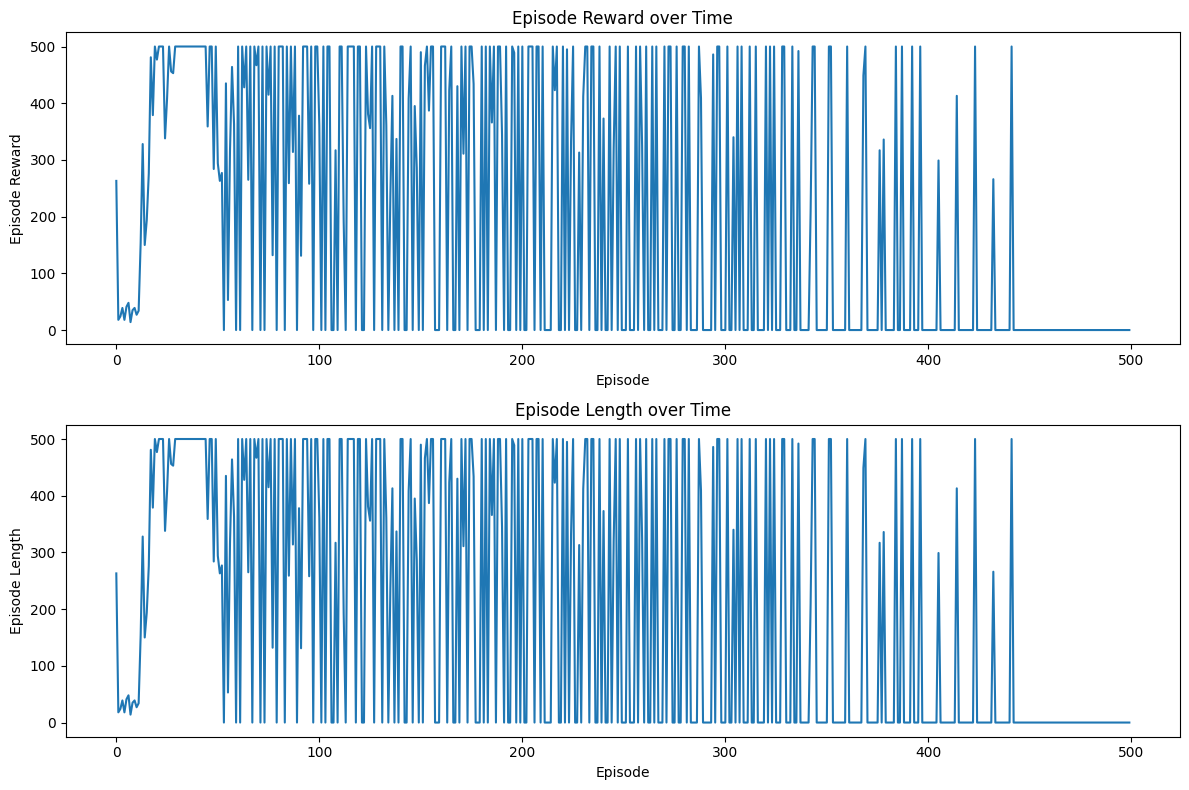

In [ ]:

def plot_results(rewards, lengths, smoothing_window=100):
    # Compute rolling mean of rewards and lengths

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(12,8))

    # Plot rewards
    axs[0].plot(rewards)
    axs[0].set_title('Episode Reward over Time'.format(smoothing_window))
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Episode Reward')

    # Plot episode lengths
    axs[1].plot(lengths)
    axs[1].set_title('Episode Length over Time'.format(smoothing_window))
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Episode Length')

    # Show plots
    plt.tight_layout()
    plt.show()

plot_results(returns, lengths)
